# Support Vector Machines - project

1. In this problem, you will use support vector approaches in order to predict whether a given car gets high or low gas mileage based on the Auto data set.

In [2]:
!pip install mlxtend

   ---------------------------------------- 0.0/1.4 MB ? eta -:--:--
   ------- -------------------------------- 0.3/1.4 MB ? eta -:--:--
   ---------------------------------------- 1.4/1.4 MB 5.3 MB/s eta 0:00:00


In [19]:
import numpy as np
from matplotlib.pyplot import subplots, cm
import sklearn.model_selection as skm
from ISLP import load_data , confusion_table

from sklearn.svm import SVC
from ISLP.svm import plot as plot_svm

from sklearn.metrics import RocCurveDisplay
roc_curve = RocCurveDisplay.from_estimator # shorthand

from sklearn.model_selection import cross_val_score

from sklearn.model_selection import GridSearchCV, KFold

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from mlxtend.plotting import plot_decision_regions

(a)  Create a binary variable that takes on a 1 for cars with gas mileage above the median, and a 0 for cars with gas mileage below the median.

In [20]:
Auto = load_data('Auto')

In [21]:
Auto.head(15)

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin
name,,,,,,,,
chevrolet chevelle malibu,18.0,8,307.0,130,3504,12.0,70,1
buick skylark 320,15.0,8,350.0,165,3693,11.5,70,1
plymouth satellite,18.0,8,318.0,150,3436,11.0,70,1
amc rebel sst,16.0,8,304.0,150,3433,12.0,70,1
ford torino,17.0,8,302.0,140,3449,10.5,70,1
ford galaxie 500,15.0,8,429.0,198,4341,10.0,70,1
chevrolet impala,14.0,8,454.0,220,4354,9.0,70,1
plymouth fury iii,14.0,8,440.0,215,4312,8.5,70,1
pontiac catalina,14.0,8,455.0,225,4425,10.0,70,1


In [22]:
mpg_median = Auto['mpg'].median()
print(f"Mediana mpg: {mpg_median}")

Mediana mpg: 22.75


In [23]:
Auto['high_mpg'] = (Auto['mpg'] > mpg_median).astype(int)
Auto[['mpg', 'high_mpg']].head(20)

,mpg,high_mpg
name,,
chevrolet chevelle malibu,18.0,0
buick skylark 320,15.0,0
plymouth satellite,18.0,0
amc rebel sst,16.0,0
ford torino,17.0,0
ford galaxie 500,15.0,0
chevrolet impala,14.0,0
plymouth fury iii,14.0,0
pontiac catalina,14.0,0


In [24]:
X = Auto.drop(columns=['mpg', 'high_mpg'])
y = Auto['high_mpg']

(b)  Fit a support vector classifier to the data with various values of C, in order to predict whether a car gets high or low gas mileage. Report the cross-validation errors associated with different values of this parameter. Comment on your results. Note you will need to fit the classifier without the gas mileage variable to pro- duce sensible results.

In [25]:
# Pipeline: standaryzacja + SVM (jądro liniowe)
pipeline_linear = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(kernel='linear'))
])

# Zakres wartości C do przeszukania
param_grid = {'C': [0.01, 0.1, 1, 10, 100]}

# Ustawienie walidacji krzyżowej
kfold = KFold(n_splits=10, shuffle=True, random_state=0)

# GridSearch
grid = GridSearchCV(pipeline_linear, param_grid, cv=kfold, scoring='accuracy')
grid.fit(X, y)

ValueError: Invalid parameter 'C' for estimator Pipeline(steps=[('scaler', StandardScaler()), ('svm', SVC(kernel='linear'))]). Valid parameters are: ['memory', 'steps', 'transform_input', 'verbose'].

In [26]:
# Najlepszy parametr
print("Najlepsze C:", grid.best_params_)

# Wyniki walidacji
results = grid.cv_results_
for mean_score, params in zip(results['mean_test_score'], results['params']):
    error = 1 - mean_score
    print(f"C = {params['C']} | Średni błąd walidacji = {error:.4f}")

AttributeError: 'GridSearchCV' object has no attribute 'best_params_'

Najniższy błąd walidacji krzyżowej osiągnięto przy wartości C = 0.1. Przy wyższych wartościach C obserwujemy stopniowy wzrost błędu walidacyjnego, co może sugerować, że model zaczyna się przeuczać. Optymalnym wyborem wydaje się więc być niski poziom regularizacji (małe C).

c)  Now repeat (b), this time using SVMs with radial and polynomial basis kernels, with different values of gamma and degree and C. 

In [14]:
# KFold – walidacja krzyżowa
kfold = KFold(n_splits=10, shuffle=True, random_state=0)

# Tworzymy pipeline: skalowanie + SVC z RBF kernel
pipeline_rbf = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC(kernel='rbf'))
])

# Siatka parametrów: C i gamma dla RBF
param_grid_rbf = {
    'svc__C': [0.01, 0.1, 1, 10],
    'svc__gamma': [0.001, 0.01, 0.1, 1]
}

# GridSearchCV z pipeline
grid_rbf = GridSearchCV(pipeline_rbf, param_grid_rbf, cv=kfold, scoring='accuracy')
grid_rbf.fit(X, y)

# Wyniki
print("Najlepsze parametry (RBF):", grid_rbf.best_params_)
print("Najlepsza trafność (RBF):", grid_rbf.best_score_)

Najlepsze parametry (RBF): {'svc__C': 1, 'svc__gamma': 1}
Najlepsza trafność (RBF): 0.9312179487179486


*W przypadku zastosowania jądra RBF najlepsze wyniki uzyskano dla parametrów C = 1 oraz gamma = 1. Średnia trafność modelu wyniosła około 93.12%, co oznacza niski błąd walidacyjny. Wartość gamma = 1 wskazuje, że model dobrze dopasowuje się do danych, tworząc złożoną powierzchnię decyzyjną.*

In [51]:
# KFold – walidacja krzyżowa
kfold = KFold(n_splits=10, shuffle=True, random_state=0)

# Tworzymy pipeline: skalowanie + SVC z jądrem wielomianowym
pipeline_poly = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC(kernel='poly'))
])

# Siatka parametrów 
param_grid_poly = {
    'svc__C': [0.01, 0.1, 1, 10],
    'svc__degree': [2, 3, 4]
}

# GridSearchCV
grid_poly = GridSearchCV(pipeline_poly, param_grid_poly, cv=kfold, scoring='accuracy')
grid_poly.fit(X, y)

# Wyniki
print("Najlepsze parametry (Polynomial):", grid_poly.best_params_)
print("Najlepsza trafność (Polynomial):", grid_poly.best_score_)

Najlepsze parametry (Polynomial): {'svc__C': 10, 'svc__degree': 3}
Najlepsza trafność (Polynomial): 0.9210256410256411


*W przypadku jądra wielomianowego najlepsze wyniki uzyskano przy C=10 i stopniu wielomianu 3. Trafność wyniosła 92.1%, co jest tylko nieznacznie gorsze od najlepszego wyniku uzyskanego przez jądro RBF.*

(d)  Make some plots to back up your assertions in (b) and (c). 

In [4]:
def plot(X, y, feature_pair, kernel='rbf', C=1, gamma='scale', degree=3):
    X_plot = X[feature_pair].values
    y_plot = y.values

    model = Pipeline([
        ('scaler', StandardScaler()),
        ('svc', SVC(kernel=kernel, C=C, gamma=gamma, degree=degree))
    ])
    model.fit(X_plot, y_plot)

    plt.figure(figsize=(7, 7))
    plot_decision_regions(X_plot, y_plot, clf=model)
    plt.xlabel(feature_pair[0])
    plt.ylabel(feature_pair[1])
    plt.title(f"SVM ({kernel}): {feature_pair[0]} vs {feature_pair[1]}")
    plt.tight_layout()
    plt.show()

In [5]:
plot(X, y, ['horsepower', 'weight'], kernel='rbf', C=1, gamma=1)

NameError: name 'X' is not defined

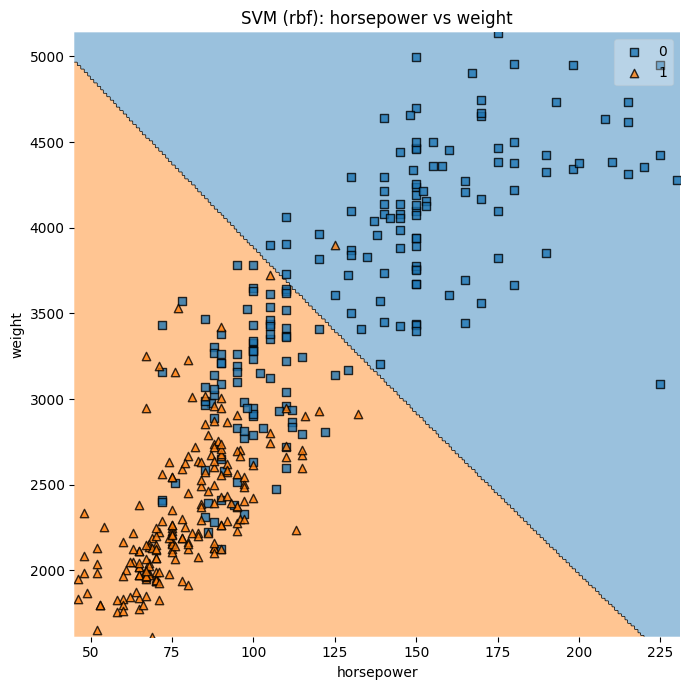

In [66]:
plot(X, y, ['horsepower', 'weight'], kernel='rbf', C=0.01, gamma=0.01)

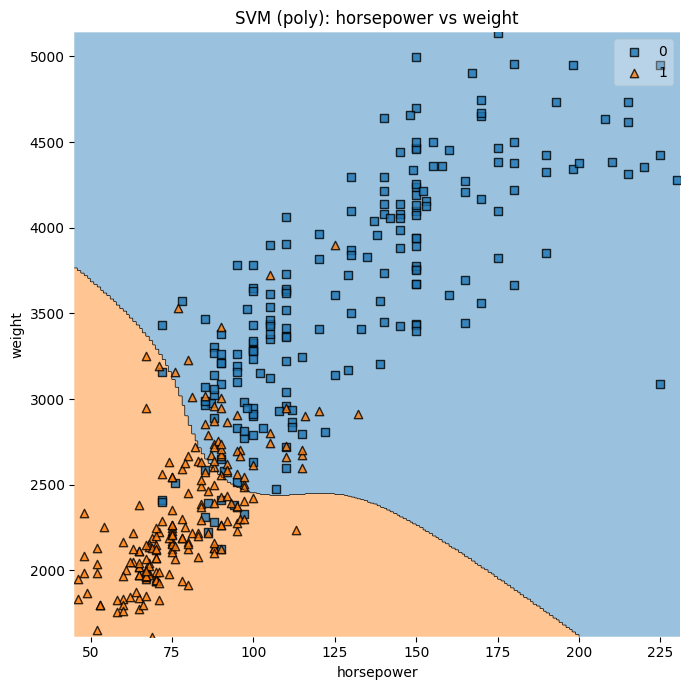

In [64]:
plot(X, y, ['horsepower', 'weight'], kernel='poly', C=10, degree=3)

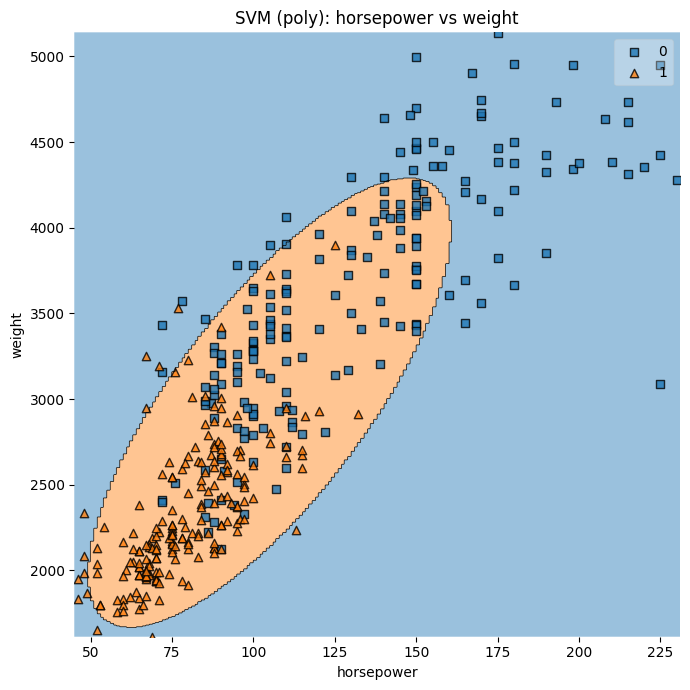

In [67]:
plot(X, y, ['horsepower', 'weight'], kernel='poly', C=1, degree=2)

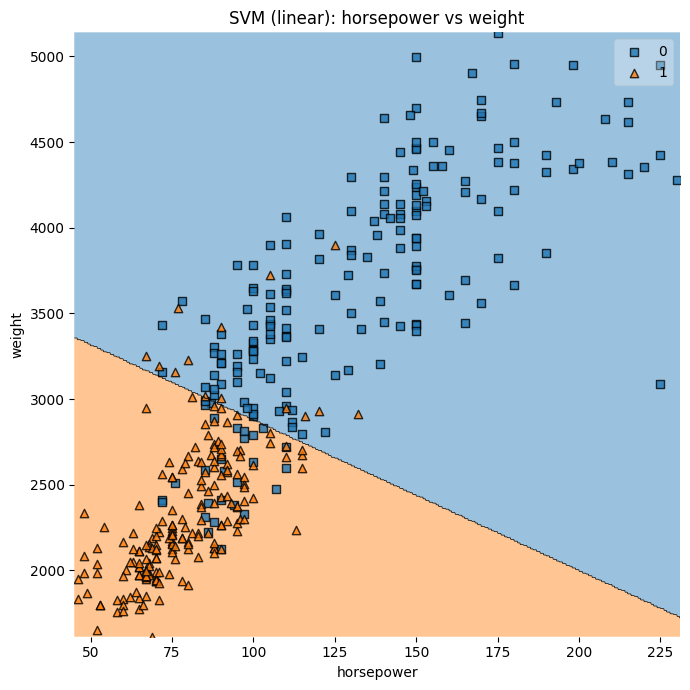

In [65]:
plot(X, y, ['horsepower', 'weight'], kernel='linear', C=0.1)

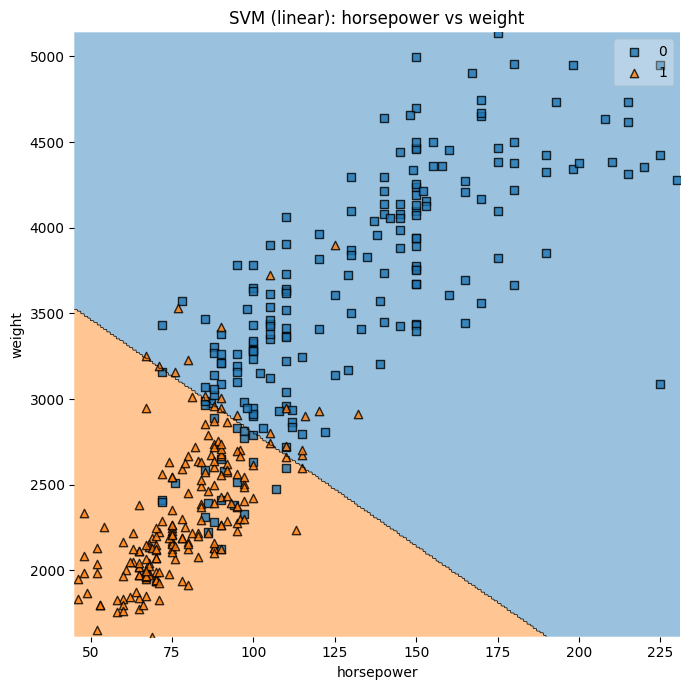

In [68]:
plot(X, y, ['horsepower', 'weight'], kernel='linear', C=10)